<font size=15> Entrenamiento del modelo final

# Bibliotecas

In [2]:
library(xgboost)
library(data.table)
library(ggplot2)

# Datos

## Cargar los datos de los archivos ".csv"

In [3]:
# Cargar datos
train_set <- fread("/kaggle/input/ameshousing-train-set/AmesHousing_train_set.csv")
test_set <- fread("/kaggle/input/ameshousing-test-set/AmesHousing_test_set.csv")

## Separar datos entre X y Y respectivamente para los conjuntos train y test

In [4]:
# Conjunto de entrenamiento
x_train <- train_set[, -"sale_price", with = FALSE]
y_train <- train_set$sale_price
# Conjunto de prueba (generalización)
x_test <- test_set[, -"sale_price", with = FALSE]
y_test <- test_set$sale_price

## Conversión de datos a DMatrix

In [5]:
# Convertir a DMatrix
dtrain <- xgb.DMatrix(data = as.matrix(x_train), label = y_train)
dtest <- xgb.DMatrix(data = as.matrix(x_test), label = y_test)

# Entrenamiento del modelo

## Declaración de hiperparámetros

Los hiperparámetros presentados se obtuvieron tras realizar una búsqueda exhaustiva mediante la técnica de búsqueda por malla con validación cruzada.

In [6]:
# Hiperparámetros del modelo XGBoost para el problema de regresión
params <- list(
  booster = "gbtree", # Tipo de modelo a construir: árbol de impulso de gradiente.
  objective = "reg:squarederror", # Función de pérdida: Error Cuadrático Medio (RMSE).
  nthread = -1, # Número de hilos de procesamiento paralelo: usar todos los disponibles.
  eta = 0.02, # Tasa de aprendizaje: determina el paso en la actualización de pesos.
  max_depth = 4, # Máxima profundidad de cada árbol: previene el sobreajuste.
  min_child_weight = 3, # Suma mínima de pesos de todas las observaciones requeridas en un niño.
  subsample = 0.7, # Fracción de muestras a utilizar para cada árbol: previene el sobreajuste.
  colsample_bytree = 0.3, # Fracción de características a utilizar para cada árbol.
  alpha = 1000, # Término de regularización L1 en el costo: aumenta la penalización sobre la complejidad del modelo.
  lambda = 1, # Término de regularización L2 en el costo: suaviza la actualización de pesos.
  tree_method = "exact" # Método de construcción del árbol: usa algoritmo exacto para encontrar las mejores divisiones.
)

## Ejecutar el entrenamiento

Para medir el tiempo de ejecución podemos usar system.time. Dentro de la línea se coloca el modelo.

In [7]:
# Entrenar el modelo
system.time({
  xgb_model <- xgb.train(
    params = params,
    data = dtrain,
    nrounds = 15000,
    watchlist = list(train = dtrain, eval = dtest),
    print_every_n = 50,
#     early_stopping_rounds = 1000
  )
})

[1]	train-rmse:191855.754606	eval-rmse:202116.862228 
[51]	train-rmse:76702.036379	eval-rmse:83691.186177 
[101]	train-rmse:36350.942657	eval-rmse:43685.543116 
[151]	train-rmse:23275.064797	eval-rmse:31324.106741 
[201]	train-rmse:19126.496656	eval-rmse:27749.346047 
[251]	train-rmse:17328.566600	eval-rmse:26384.915289 
[301]	train-rmse:16290.326744	eval-rmse:25728.530081 
[351]	train-rmse:15483.974676	eval-rmse:25343.377803 
[401]	train-rmse:14903.697944	eval-rmse:24986.916580 
[451]	train-rmse:14427.257583	eval-rmse:24729.811521 
[501]	train-rmse:13966.775852	eval-rmse:24621.299361 
[551]	train-rmse:13520.559644	eval-rmse:24454.206863 
[601]	train-rmse:13096.531325	eval-rmse:24319.558288 
[651]	train-rmse:12732.424164	eval-rmse:24190.144437 
[701]	train-rmse:12406.406105	eval-rmse:24064.506022 
[751]	train-rmse:12094.413442	eval-rmse:23973.347713 
[801]	train-rmse:11771.306601	eval-rmse:23875.448984 
[851]	train-rmse:11475.732213	eval-rmse:23800.415745 
[901]	train-rmse:11222.193885

   user  system elapsed 
175.437   2.002  45.692 

# Resultados

## Extraer resultados de evaluación

In [8]:
# Extraer resultados de evaluación
evals_result <- xgb_model$evaluation_log
print(names(evals_result))

[1] "iter"       "train_rmse" "eval_rmse" 


Las variables que nos interesan son "train_rmse" y "eval_rmse" 

In [9]:
# Crear un data frame para graficar
results_df <- data.frame(
  Estimador = 1:nrow(evals_result),
  Train_RMSE = evals_result$train_rmse,
  Test_RMSE = evals_result$eval_rmse
)

In [10]:
head(results_df)

,Estimador,Train_RMSE,Test_RMSE
,<int>,<dbl>,<dbl>
1,1,191855.8,202116.9
2,2,188182.1,198285.0
3,3,184646.2,194668.4
4,4,181204.0,191121.6
5,5,177785.8,187631.1
6,6,174425.9,184142.8


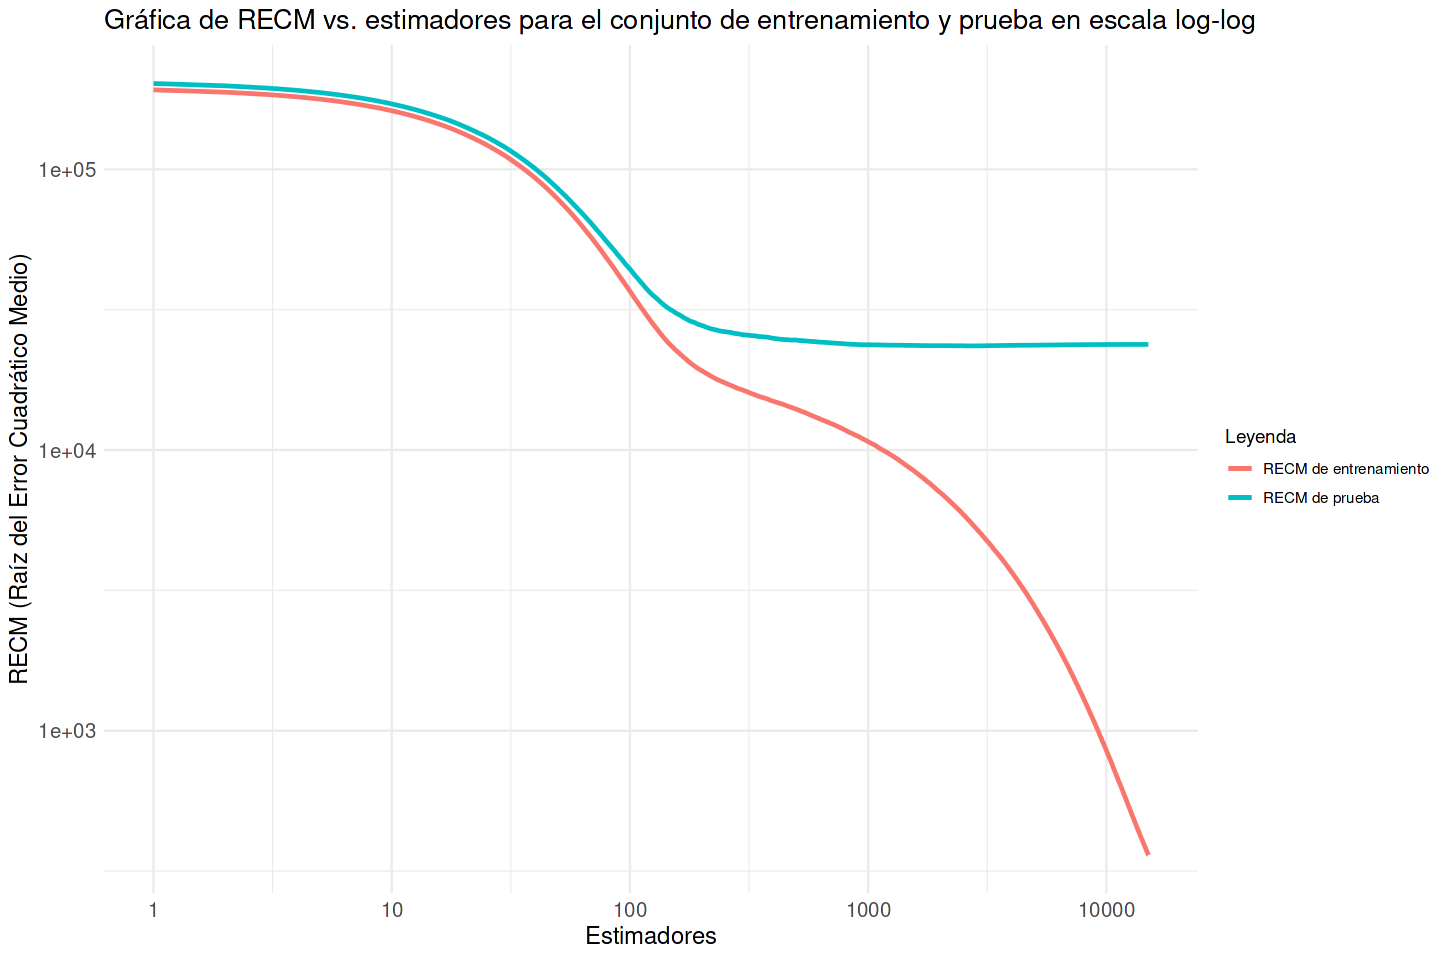

In [22]:
options(repr.plot.width = 12, repr.plot.height = 8)
# Graficar usando ggplot2
ggplot(data = results_df) +
  geom_line(aes(x = Estimador, y = Train_RMSE, colour = "RECM de entrenamiento"), linewidth = 1) +
  geom_line(aes(x = Estimador, y = Test_RMSE, colour = "RECM de prueba"), linewidth = 1) +
  scale_x_log10() +
  scale_y_log10() +
  labs(x = "Estimadores", y = "RECM (Raíz del Error Cuadrático Medio)", colour = "Leyenda", title="Gráfica de RECM vs. estimadores para el conjunto de entrenamiento y prueba en escala log-log") +
  theme_minimal()+
  theme(
    axis.title.x = element_text(size = 14), # Tamaño de la etiqueta del eje X
    axis.title.y = element_text(size = 14), # Tamaño de la etiqueta del eje Y
    plot.title = element_text(size = 16),    # Tamaño del título
    axis.text.x = element_text(size = 12),  # Tamaño del texto de los ticks del eje X
    axis.text.y = element_text(size = 12)   # Tamaño del texto de los ticks del eje Y
  )

In [24]:
min_test_rmse <- min(results_df$Test_RMSE)
position_min_test_rmse <- which.min(results_df$Test_RMSE)

print(paste("El valor mínimo de Test_RMSE es:", min_test_rmse))
print(paste("La posición del valor mínimo es:", position_min_test_rmse))

[1] "El valor mínimo de Test_RMSE es: 23482.7712870683"
[1] "La posición del valor mínimo es: 2658"


In [25]:
# Calcular la importancia de las características
importance_matrix <- xgb.importance(model = xgb_model)

# Crear un data.frame de la matriz de importancia para una mejor visualización
importance_df <- xgb.importance(feature_names = colnames(dtrain), model = xgb_model)

# Imprimir las características más importantes
print(importance_df)


            Feature         Gain        Cover    Frequency
 1:    overall_qual 2.344258e-01 1.512292e-02 1.403025e-02
 2:     gr_liv_area 1.131146e-01 5.888356e-02 5.518135e-02
 3:     garage_cars 8.319452e-02 4.792648e-03 4.841597e-03
 4:      year_built 6.089774e-02 4.026804e-02 3.860914e-02
 5:     garage_area 5.387585e-02 5.149591e-02 5.025073e-02
 6:       bsmt_qual 5.251883e-02 5.344851e-03 6.048287e-03
 7:   total_bsmt_sf 4.399368e-02 5.310270e-02 4.900448e-02
 8:      1st_flr_sf 3.715177e-02 5.537788e-02 5.172448e-02
 9:    kitchen_qual 3.628968e-02 5.536002e-03 6.077960e-03
10:    bsmtfin_sf_1 3.520666e-02 5.056284e-02 4.708565e-02
11:      exter_qual 2.929820e-02 3.733708e-03 4.154179e-03
12:  year_remod/add 2.131346e-02 2.961654e-02 3.195256e-02
13:      2nd_flr_sf 2.040729e-02 3.007184e-02 2.670049e-02
14:      fireplaces 2.034819e-02 5.556326e-03 7.032432e-03
15:        lot_area 1.932235e-02 7.554044e-02 6.631851e-02
16:   garage_finish 1.286156e-02 6.657763e-03 8.446831e-

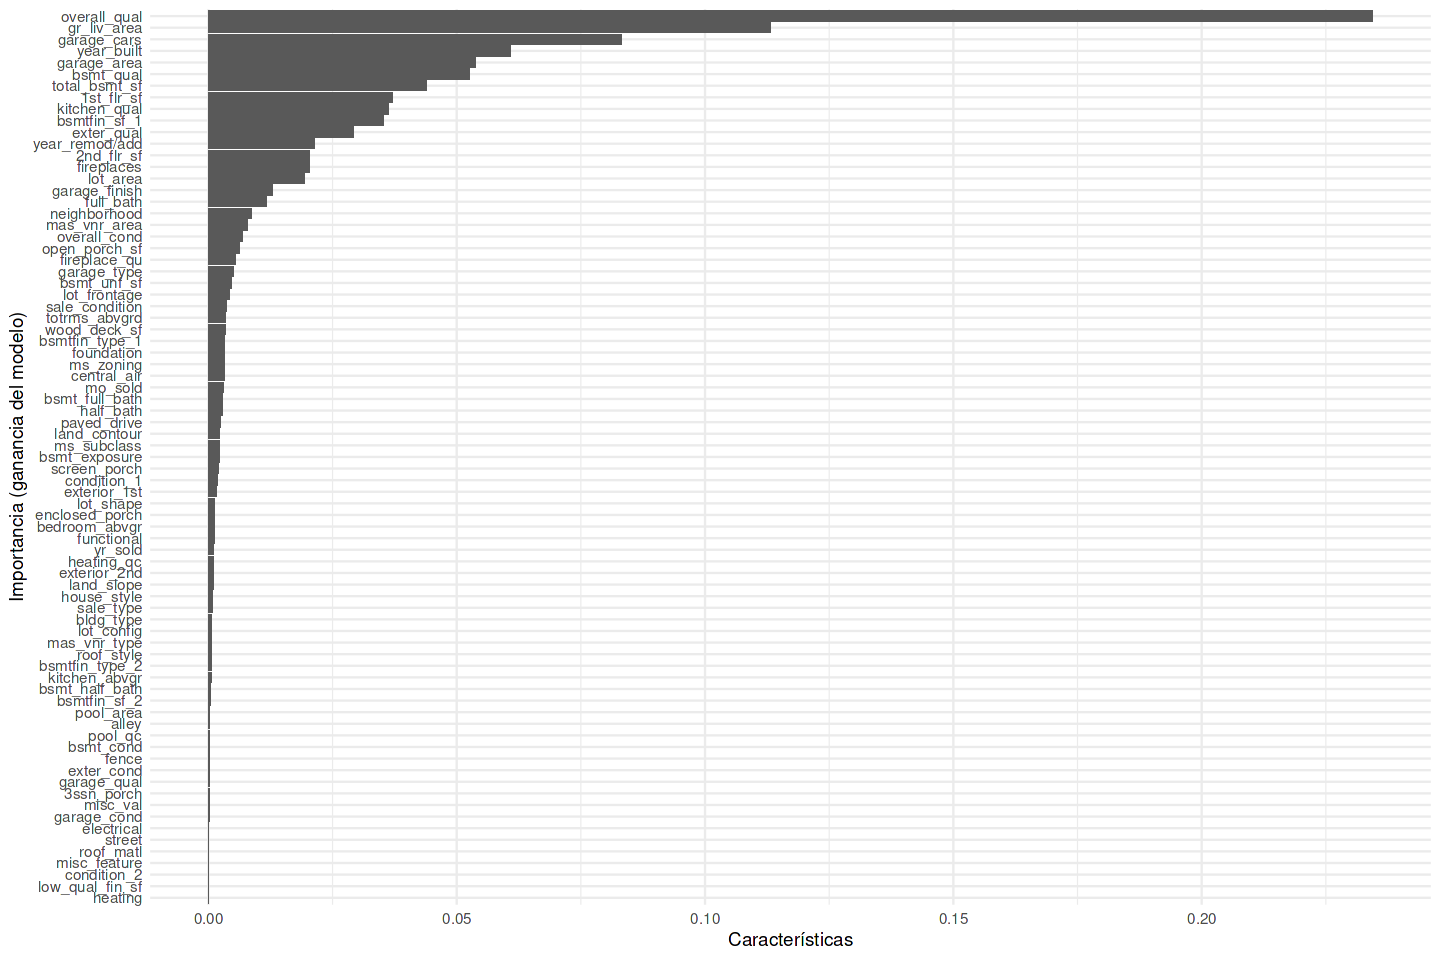

In [26]:
library(ggplot2)
library(xgboost)

# Asumiendo que 'xgb_model' es tu modelo ya entrenado
importance_matrix <- xgb.importance(feature_names = colnames(dtrain), model = xgb_model)

# Crear la gráfica de barras usando ggplot2
ggplot(importance_matrix, aes(x = reorder(Feature, Gain), y = Gain)) +
  geom_bar(stat = "identity") +
  coord_flip() + # Esto pone las características en el eje y y las ganancias en el eje x
  xlab("Importancia (ganancia del modelo)") +
  ylab("Características") +
  theme_minimal()